# Разработка системы распознавания предметов интерьера в потоковом видео

## Часть 3: Перекодирование масок

In [12]:
%matplotlib inline

#System
import os
import shutil
import random

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread, imshow, imsave

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

### 1. Подготовка данных

Считаем ранее подготовленные правила кодирования классов

In [29]:
class_encoded = []
with open('data/ADE20K_filtred/class_encode.txt') as f:
    for line in f:
        line = line.strip()
        new_index, old_index_arr, class_name_arr = line.split(";")
        
        new_index = int(new_index)
        old_index_arr = list(map(int, old_index_arr.split("|")))
        class_name_arr = class_name_arr.split("|")
        class_encoded.append([new_index, old_index_arr, class_name_arr])

class_encoded

[[0, [0], ['-']],
 [1, [2977, 975, 446], ['wall', 'floor, flooring', 'ceiling']],
 [2,
  [470, 2678, 2271, 56, 2585, 180],
  ['chair', 'swivel chair', 'seat', 'armchair', 'stool', 'bench']],
 [3, [1734, 790], ['painting, picture', 'drawing']],
 [4,
  [349, 2328, 238, 2984, 2035],
  ['cabinet', 'shelf', 'bookcase', 'wardrobe, closet, press', 'rack']],
 [5,
  [3054, 211, 2421, 1746],
  ['windowpane, window',
   'blind, screen',
   'skylight, fanlight',
   'pane, pane of glass, window glass']],
 [6,
  [2683, 3086, 723, 570, 1373, 626, 593],
  ['table',
   'work surface',
   'desk',
   'coffee table, cocktail table',
   'kitchen island',
   'counter',
   'console table, console']],
 [7,
  [1450, 1394, 2242, 377, 2508, 375, 981, 1444, 372, 479],
  ['light, light source',
   'lamp',
   'sconce',
   'candlestick, candle holder',
   'spotlight, spot',
   'candle, taper, wax light',
   'fluorescent, fluorescent fixture',
   'light bulb, lightbulb, bulb, incandescent lamp, electric light, electr

Создадим словарь перевода старых индексов в новые

In [31]:
index_old_to_new_dict = dict()

for i in range(len(segEncoder.obj_names)):
    index_old_to_new_dict[i] = 0

for line in class_encoded:
    new_index = line[0]
    old_index_arr = line[1]
    for old_index in old_index_arr:
        index_old_to_new_dict[old_index] = new_index
        
index_old_to_new_dict

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 29,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 26,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 2,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 28,


### 3. Перекодирование масок

In [101]:
def get_encoded_seg(seg):
    R = seg[:, :, 0]
    G = seg[:, :, 1]
    B = seg[:, :, 2]

    new_seg = (R / 10 * 256 + G).astype(np.uint16)
    new_seg[new_seg != 0] -= 1
    
    old_list = sorted(index_old_to_new_dict.keys())
    for old in old_list:
        new_seg[new_seg == old] = index_old_to_new_dict[old]

    return new_seg

In [80]:
new_seg

Array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [54]:
seg = imread("data/ADE20K_filtred/images/train/c/computer_room/" + "ADE_train_00005939_seg.png")
img = imread("data/ADE20K_filtred/images/train/c/computer_room/" + "ADE_train_00005939.jpg")

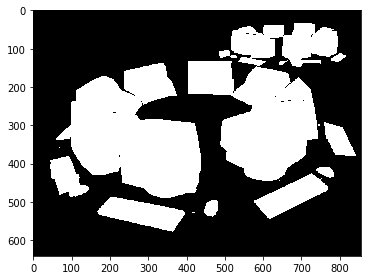

In [81]:
imshow(new_seg == 18, cmap='gray')

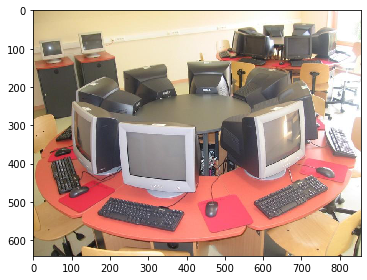

In [55]:
imshow(img)

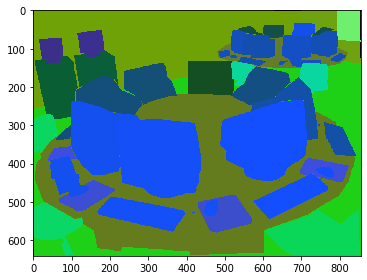

In [49]:
imshow(seg)

In [104]:
%%time
new_seg = get_encoded_seg(seg)

CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 249 ms


### Генерирование новой обучающей выборки

In [105]:
def get_format(file_name):
    name_split = file_name.split("_")
    file_format = name_split[0:-1] + name_split[-1].split(".")
    ade, train_or_val, name = file_format[:3]
    extension = file_format[-1]
    
    description = 0
    parts_num = 0
    if extension == 'jpg':
        description = 'img'
    elif extension == 'txt':
        description = 'text'
    else: #png
        description = file_format[3]
        if file_format[4].isdigit():
            parts_num = int(file_format[4])
    return [name, description, train_or_val, parts_num]

In [106]:
%%time

dir_path = 'data/ADE20K_filtred/images/train/'

img_dst_train = 'data/ADE20K_encoded/train/img/'
mask_dst_train = 'data/ADE20K_encoded/train/mask/'

img_dst_val = 'data/ADE20K_encoded/val/img/'
mask_dst_val = 'data/ADE20K_encoded/val/mask/'

s = 0
for path, dirs, files in os.walk(dir_path):
        if files:
            for file in files:
                name, description, train_or_val, parts_num = get_format(file)
                
                img_dst = img_dst_train
                mask_dst = mask_dst_train
                if train_or_val == 'val':
                    img_dst = img_dst_val
                    mask_dst = mask_dst_val
                
                if description == 'img':
                    img_path = path + '/' + file
                    shutil.copyfile(img_path, img_dst + name + '.jpg')
                    s += 1
                    
                    if s % 100 == 0:
                        print(s)
                    
                elif description == 'seg':
                    seg_path = path + '/' + file
                    seg = imread(seg_path)
                    new_seg = get_encoded_seg(seg)
                    imsave(mask_dst + name + '.png', new_seg)
                
print("Done!")

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016714.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001769.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016711.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016713.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016292.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016294.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016284.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016280.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001775.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001773.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016825.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016820.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016804.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016792.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016791.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00016808.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000775.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001488.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010749.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010752.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010748.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010751.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010206.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010152.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010347.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001481.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010162.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010180.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000462.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010365.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010677.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010490.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010622.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010474.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010610.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010324.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000639.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001470.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010557.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010701.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010454.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000646.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010187.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010605.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000632.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010735.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010367.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010259.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010272.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001478.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010266.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010309.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000963.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010321.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010589.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010230.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000640.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010223.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010356.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000602.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010377.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010181.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010541.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010697.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010608.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010374.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000611.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010616.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010698.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000470.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001457.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010358.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010284.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010315.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000610.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010348.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000613.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010350.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010366.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010710.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010497.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010396.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010600.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000601.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010164.png is a low contrast image
  warn('%s is a low contrast image' % fname)


700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010263.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000606.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010740.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010235.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000473.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000614.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010351.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010546.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000594.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010635.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010639.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010614.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010719.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010517.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010192.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010679.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010333.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010624.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010533.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010609.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010413.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010451.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010107.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010111.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010120.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010113.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001663.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014441.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014442.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014443.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019506.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015504.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015493.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015474.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015530.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015518.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015494.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015508.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015475.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

1000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015566.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015482.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015552.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015570.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015496.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015495.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001714.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000948.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015574.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015535.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015177.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015189.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000698.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015201.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

1100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015157.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015193.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015185.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001699.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015207.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015188.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015290.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015416.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015415.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015394.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015410.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015409.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

1200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014064.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014106.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001648.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014077.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014096.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001645.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014036.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014084.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014032.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000933.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014105.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014073.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014091.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

1300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014076.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014102.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014056.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014041.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000645.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015806.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000728.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015809.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00015801.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009925.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000447.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009956.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009926.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

1400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009934.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009951.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009958.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001447.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009954.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006820.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006831.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006829.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006827.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001305.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007177.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007147.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001308.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007224.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006991.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

1500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006887.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006876.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007194.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006957.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006969.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007243.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006961.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006878.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

1600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006999.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001324.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007038.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007096.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006870.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007178.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001949.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007220.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006971.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007097.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

1700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006869.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007230.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006936.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006950.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006845.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007107.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006998.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001950.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007075.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007229.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

1800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006858.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007242.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007078.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006966.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007245.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000319.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006904.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000322.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007115.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007029.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006976.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

1900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006920.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007135.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007234.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006742.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006743.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006767.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006761.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006772.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006768.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006744.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006816.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006766.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

2000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006793.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006817.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006737.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006792.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007409.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007407.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007358.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00007414.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000331.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000576.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006621.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006624.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006609.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

2100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006618.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006612.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006611.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006623.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006615.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013923.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013867.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013914.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001639.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013921.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013894.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013908.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013889.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013890.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013925.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

2200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013907.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013869.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013913.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013870.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00013917.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008832.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008847.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008848.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008838.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008833.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009407.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009358.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009315.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009402.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

2300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009370.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009322.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009368.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009390.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009365.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009394.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009331.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009314.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009387.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009316.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009398.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009400.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

2400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009652.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009531.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009611.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009556.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009587.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009576.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009537.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009523.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000431.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009632.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009558.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009544.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009641.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009617.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009594.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009591.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009590.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009546.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009620.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009584.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009542.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00009657.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014937.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014936.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019940.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019927.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000922.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

2600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019922.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019947.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019916.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019938.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019923.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020028.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001925.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020037.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020042.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019688.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000910.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019660.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019620.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019689.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

2700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019618.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019662.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019682.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019636.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019692.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000907.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019611.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019622.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019640.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019670.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019414.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001898.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019431.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

2800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00019418.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000899.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014871.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014868.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000251.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005633.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005604.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005605.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005620.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005951.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005942.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005947.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000266.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

2900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005094.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005098.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005099.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005100.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005102.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006549.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006540.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006532.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006545.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006057.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001267.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006030.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006136.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

3000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006097.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006123.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006101.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006027.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005987.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006071.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005981.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006122.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000268.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006060.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006052.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006037.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006084.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006077.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000273.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006142.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006100.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006061.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005405.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005402.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005399.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005400.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005398.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000245.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005472.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005464.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005501.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005499.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005470.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005482.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006564.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006565.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00006560.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000293.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004962.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005728.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005750.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005753.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005774.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005751.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005733.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005768.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005714.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005746.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005973.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005978.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005971.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005976.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00005977.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008333.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008308.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008321.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008314.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008320.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008324.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008332.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008322.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008331.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008330.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008353.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008400.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008385.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008397.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008390.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008413.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000374.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008404.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008372.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008365.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00008339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004443.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004456.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004438.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004433.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004442.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002475.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002493.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002495.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002500.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002489.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002474.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002497.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002494.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002241.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002248.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002219.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003201.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003198.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004385.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004402.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004396.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004394.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004392.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003980.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004105.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003387.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004072.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003684.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003549.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003353.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003712.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003713.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003430.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003330.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003229.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003620.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003556.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004059.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003453.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003791.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003486.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004078.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003982.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003649.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003451.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

3900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003237.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000326.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003740.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003529.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003912.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003864.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003743.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004181.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003851.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000124.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003279.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000527.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003933.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003409.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

4000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000522.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003369.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004195.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000279.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003284.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003274.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004133.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000228.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000311.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003872.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003603.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000488.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

4100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000218.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003798.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003934.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004094.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001175.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003996.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003775.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003779.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003984.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

4200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003578.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003998.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003609.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004081.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004208.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000289.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003221.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004039.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003672.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003606.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003686.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003669.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003971.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003698.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003710.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003961.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000121.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003756.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003292.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000376.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003692.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000150.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003691.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000434.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003732.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000418.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

4400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000407.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003833.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000529.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003322.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003240.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000540.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001179.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003302.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003978.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003427.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003985.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000288.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003545.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000138.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000475.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003234.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000325.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

4600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003335.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001119.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004077.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000451.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000223.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003551.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003682.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000364.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003333.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000395.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003278.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000396.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000335.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

4700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004021.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000233.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000511.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003904.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003541.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004192.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004225.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003662.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000290.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003897.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

4800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004069.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000501.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003354.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000198.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003927.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000244.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003892.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000470.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000200.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003693.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

4900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000447.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003946.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003843.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003827.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004230.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000392.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000549.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003363.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000176.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003447.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000277.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004041.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001139.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

5000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003570.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003250.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003267.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000443.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003373.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003375.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003535.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000512.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003454.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003735.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000232.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001153.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003437.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

5100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000182.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000285.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003235.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003377.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003884.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003479.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003658.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003328.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000452.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000287.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004095.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003803.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003461.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003517.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004107.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002385.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002413.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002367.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002375.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001069.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002390.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

5300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002404.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002399.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002377.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00004301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002725.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000146.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000076.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002663.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000104.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000073.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002541.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000149.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

5400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002536.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002790.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000066.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002542.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002718.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002566.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000065.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002867.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002950.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002739.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002700.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

5500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001096.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000097.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002994.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002753.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000083.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/pyt

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000039.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000139.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002842.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002676.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002628.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002694.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002925.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000036.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002798.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002544.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002914.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002899.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002961.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002874.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002797.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002697.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002955.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002794.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002573.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002970.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000115.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000104.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002789.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002567.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002624.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000137.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002754.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002681.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002824.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002839.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000136.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000111.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002911.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002938.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002766.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

5800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002582.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002600.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000101.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000107.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000084.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002820.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002815.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002720.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002998.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001082.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000176.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000027.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

5900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002642.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002591.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002949.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002976.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002545.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002964.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002929.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001091.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002864.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000163.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000133.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002896.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

6000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002780.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001095.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002940.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000064.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00003016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002691.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002714.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002678.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000190.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00002939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020179.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020188.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020145.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020175.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020168.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020186.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00020148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001223.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001222.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001837.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001818.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001831.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001826.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001822.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001832.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00014248.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000041.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

6200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001905.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001887.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001931.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001901.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001964.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001958.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001934.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001900.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001884.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001886.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001928.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001966.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001866.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001860.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00001864.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011565.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011562.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001534.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001533.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000535.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/pyt

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011554.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011556.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011527.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011525.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011551.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010766.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010767.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010764.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010763.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00010765.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000763.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000803.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000740.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000906.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000757.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011416.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000738.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011409.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011228.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000804.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011252.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000798.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011441.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000828.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000775.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000743.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011245.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000866.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000735.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000842.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011240.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000854.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011484.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000660.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011370.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011112.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011178.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011116.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000863.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000685.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011146.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011415.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000783.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000751.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000716.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001969.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011193.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011188.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000753.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011105.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000508.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011309.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001528.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/p

6700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000656.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011096.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000510.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011347.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011280.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000821.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000672.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000967.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011239.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011451.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000778.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000807.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011207.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000782.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011502.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011408.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000718.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000823.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011115.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011436.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000800.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000799.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000734.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011488.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000787.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000902.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011507.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011140.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

6900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011279.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000728.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000714.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011457.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000860.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000887.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011231.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011183.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011346.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001521.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

7000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000929.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000717.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001966.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011362.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000756.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000809.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011440.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000795.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011272.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011160.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00001506.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011371.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000925.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011182.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011477.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

7100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000884.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000695.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011330.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011366.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/val/mask/00000520.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011359.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011483.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000784.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000651.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00000873.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/l

Done!
CPU times: user 2h 7min 13s, sys: 27.5 s, total: 2h 7min 40s
Wall time: 2h 10min 15s


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_encoded/train/mask/00011224.png is a low contrast image
  warn('%s is a low contrast image' % fname)
